In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *

## Define and Collect Trajectories of the Nonlinear System

In [2]:
def nonlinear_system(t,X,params):
    # define system parameters
    mu = params[0]
    lam = params[1]
    # specify rate of change of each state
    dx1dt = mu*X[0]
    dx2dt = lam*(X[1]-X[0]**2)
    # roll up states into a numpy array
    dXdt = np.asarray([dx1dt,dx2dt])
    
    return dXdt

In [3]:
# initial condition
initial_state = [-3.5,2]
dt = 0.01
final_time = 100
t_vec = np.arange(0,final_time+dt,dt)
tspan = np.asarray([0,final_time])
mu = -0.05
lam = -1
params = np.asarray([mu,lam])

states = solve_ivp(nonlinear_system, tspan, initial_state, t_eval = t_vec, args = (params,))

t = states.t
x = states.y

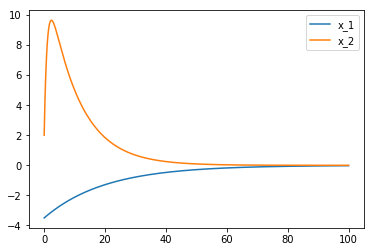

In [4]:
# plot trajectories
plt.plot(t,x[0,:], label = "x_1")
plt.plot(t,x[1,:], label = "x_2")
plt.legend()

## Perform DMD with and without Time Delay Embeddings and Visualize Mode Spectrum

In [5]:
def DMD(X,Xprime,r):
    ''' This function computes the linear approximation to a nonlinear dynamical system whose state 
    recordings are passed in.
    
    Arguments:
    
    Input:
    
        X: The states of the system
        
        Xprime: the rate of change of the states obtained form finite differencing or direct measurement
        
        r: the rank of the low-rank approximation
        
    Output:
    
        Phi: State transition matrix
        
        Lambda: Eigenvalues of Atilde
        
        b: Amplitude of the modes
    '''
    
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

In [6]:
X = x[:,0:-1]
Xprime = x[:,1:]

# obtain DMD model
r = 3 # enter the value of r
Phi, Lambda, b = DMD(X[:,:],Xprime[:,:],r)
omega = np.log(np.diag(Lambda))/dt

In [7]:
# reconstruct dynamics with DMD as a sanity check

time_dynamics = np.zeros([2,len(t_vec)-1])

for i in range(time_dynamics.shape[1]):
    time_dynamics[:,i] = b*np.exp(omega*t_vec[i])
    
X_dmd = np.dot(Phi,time_dynamics)

Text(0, 0.5, 'Population')

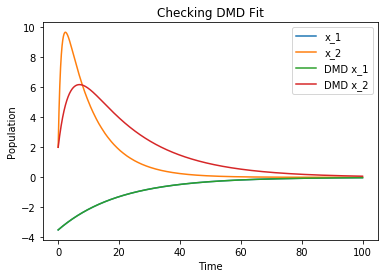

In [8]:
# plot to compare the DMD modes to the actual data
t = t_vec[:-1]
plt.plot(t,X[0,:],label='x_1')
plt.plot(t,X[1,:],label='x_2')
plt.plot(t,X_dmd[0,:],label='DMD x_1')
plt.plot(t,X_dmd[1,:],label='DMD x_2')
plt.legend()
plt.title("Checking DMD Fit")
plt.xlabel('Time')
plt.ylabel('Population')

(100, 9900)


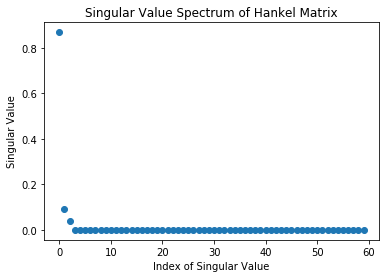

In [9]:
# time delay embedding

## Eigen-time delay coordinates
stackmax = 100 # Number of shift-stacked rows
r = 60  # rank of HAVOK model
num_states = 2
H = np.zeros((stackmax,X.shape[1]-stackmax))


for k in range(0,stackmax,num_states):
    H[k:k+2,:] = X[:,k:-(stackmax-k)]
  
U,S,VT = np.linalg.svd(H,full_matrices=0)
V = VT.T

S = S[:r]

plt.plot(S/np.sum(S),'o')
plt.title('Singular Value Spectrum of Hankel Matrix')
plt.ylabel('Singular Value')
plt.xlabel('Index of Singular Value')
print(H.shape)

In [10]:
latent_vars = np.where(S>1)[0]
print(latent_vars)

[0 1 2]


In [11]:
S

array([2.00120274e+03, 2.14588843e+02, 8.63534347e+01, 1.32295989e-01,
       5.89988230e-02, 1.84478053e-02, 6.08516887e-03, 2.75132855e-03,
       1.52906252e-03, 7.94102060e-04, 5.15702640e-04, 3.39382596e-04,
       2.28419474e-04, 1.68531334e-04, 1.25796850e-04, 9.18507212e-05,
       7.55285251e-05, 5.69358378e-05, 4.70251076e-05, 3.96278439e-05,
       3.13610221e-05, 2.79153674e-05, 2.31788661e-05, 1.97367022e-05,
       1.76306655e-05, 1.45936130e-05, 1.31062283e-05, 1.14274139e-05,
       9.93009206e-06, 9.07400579e-06, 7.93381323e-06, 7.19128804e-06,
       6.60725843e-06, 5.80804047e-06, 5.38728525e-06, 4.83491149e-06,
       4.39010987e-06, 4.06219650e-06, 3.64897147e-06, 3.40239838e-06,
       3.11141317e-06, 2.88201895e-06, 2.69428588e-06, 2.49453331e-06,
       2.35926537e-06, 2.22121442e-06, 2.11238459e-06, 2.03061722e-06,
       1.95362927e-06, 1.91340289e-06, 1.88365579e-06, 7.80104762e-07,
       2.43803185e-07, 4.42229018e-08, 2.08615818e-08, 9.19549201e-09,
      

In [12]:
# create the X and Xprime matrices of the dimelayed embeddings to pass to the DMD function
X_delay_prime = H[:,1:]
X_delay = H[:,:-1]

print(X_delay.shape,X_delay_prime.shape)
# obtain Time Delayed DMD model
r = 2 # enter the value of r
Phi_delay, Lambda_delay, b_delay = DMD(X_delay,X_delay_prime,r)
omega_delay = np.log(np.diag(Lambda_delay))/dt

print('Phi =',Phi_delay,'\n')
print('Lambda =',Lambda_delay,'\n')
print('b = ',b_delay,'\n')
print('Omega =',omega_delay)

(100, 9899) (100, 9899)
Phi = [[-0.00131016-0.00874987j -0.00131016+0.00874987j]
 [ 0.14411134-0.00381828j  0.14411134+0.00381828j]
 [-0.00130885-0.00874112j -0.00130885+0.00874112j]
 [ 0.14403597-0.00379593j  0.14403597+0.00379593j]
 [-0.00130755-0.00873238j -0.00130755+0.00873238j]
 [ 0.14395653-0.00377392j  0.14395653+0.00377392j]
 [-0.00130624-0.00872366j -0.00130624+0.00872366j]
 [ 0.14387312-0.00375224j  0.14387312+0.00375224j]
 [-0.00130493-0.00871494j -0.00130493+0.00871494j]
 [ 0.14378582-0.00373087j  0.14378582+0.00373087j]
 [-0.00130363-0.00870623j -0.00130363+0.00870623j]
 [ 0.14369473-0.00370983j  0.14369473+0.00370983j]
 [-0.00130233-0.00869752j -0.00130233+0.00869752j]
 [ 0.14359993-0.00368909j  0.14359993+0.00368909j]
 [-0.00130102-0.00868883j -0.00130102+0.00868883j]
 [ 0.14350152-0.00366866j  0.14350152+0.00366866j]
 [-0.00129972-0.00868015j -0.00129972+0.00868015j]
 [ 0.14339958-0.00364854j  0.14339958+0.00364854j]
 [-0.00129842-0.00867147j -0.00129842+0.00867147j]
 

In [13]:
# reconstruct dynamics with DMD as a sanity check

time_dynamics_delay = np.zeros([2,X_delay.shape[1]-1])

for i in range(time_dynamics_delay.shape[1]):
    time_dynamics_delay[:,i] = b_delay*np.exp(omega_delay*t_vec[i])
    
X_dmd_delay = np.dot(Phi_delay,time_dynamics_delay)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


/home/ashwin/.local/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'State')

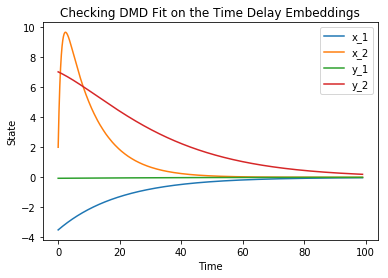

In [14]:
X_dmd_delay_model = X_dmd_delay[:,:]

# plot to compare the DMD modes to the actual data
end_delay = X_dmd_delay_model.shape[1]
t_delay = t[:end_delay]
plt.plot(t_delay,X[0,:end_delay],label='x_1')
plt.plot(t_delay,X[1,:end_delay],label='x_2')
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y_1')
plt.plot(t_delay,X_dmd_delay_model[1,:],label='y_2')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

## Compare against the Linearized System

In [15]:
def linear_system(t,Y,params):

    mu = params[0]
    lam = params[1]
    
    dy1dt = mu*Y[0]
    dy2dt = lam*Y[1]-lam*Y[2]
    dy3dt = 2*mu*Y[2]
    
    dYdt = np.asarray([dy1dt,dy2dt,dy3dt])
    
    return dYdt
    

In [16]:
def intrinsic_coords(x):
    y0 = x[0]
    y1 = x[1]
    y2 = x[0]**2
    
    y = np.asarray([y0,y1,y2])
    
    return y


In [17]:
initial_state_linear = intrinsic_coords(initial_state)

states_lin = solve_ivp(linear_system, tspan, initial_state_linear, t_eval = t_delay, args = (params,))

t_lin = states_lin.t
x_lin = states_lin.y

/home/ashwin/.local/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'State')

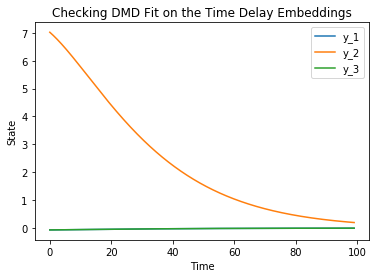

In [18]:
# plot to compare the DMD modes to the actual data
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y_1')
plt.plot(t_delay,X_dmd_delay_model[1,:],label='y_2')
plt.plot(t_delay,X_dmd_delay_model[2,:],label='y_3')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

Text(0, 0.5, 'State')

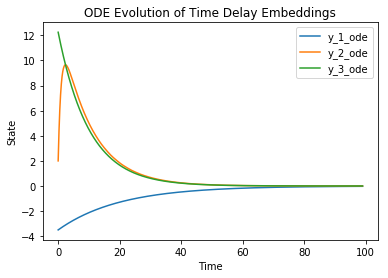

In [19]:
# plot to compare the DMD modes to the actual data
plt.plot(t_lin,x_lin[0,:],label='y_1_ode')
plt.plot(t_lin,x_lin[1,:],label='y_2_ode')
plt.plot(t_lin,x_lin[2,:],label='y_3_ode')
plt.legend()
plt.title("ODE Evolution of Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

/home/ashwin/.local/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


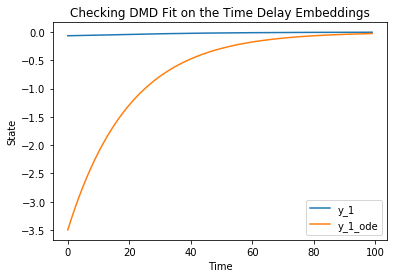

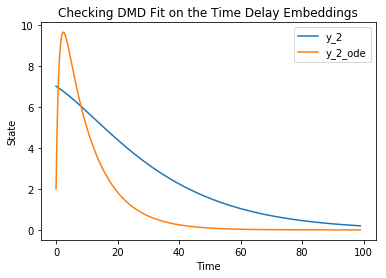

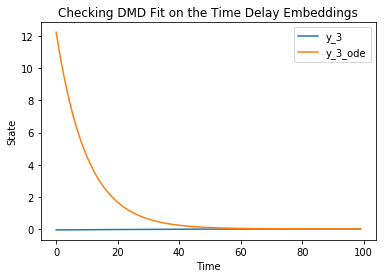

In [20]:
# plot to compare the DMD modes to the actual data
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y_1')
plt.plot(t_lin,x_lin[0,:],label='y_1_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

plt.plot(t_delay,X_dmd_delay_model[1,:],label='y_2')
plt.plot(t_lin,x_lin[1,:],label='y_2_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

plt.plot(t_delay,X_dmd_delay_model[2,:],label='y_3')
plt.plot(t_lin,x_lin[2,:],label='y_3_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

## Forecasting with Koopman

$\dot{x_1} = \mu x_1$

$\dot{x_2} = \lambda(x_2-x_1^2)$

$
\frac{d}{dt}\begin{bmatrix}
y_1 \\
y_2 \\
y_ 3
\end{bmatrix} = \begin{bmatrix}
\mu & 0 & 0\\
0 & \lambda & -\lambda \\
0 & 0 & 2\mu
\end{bmatrix}\begin{bmatrix}
y_1 \\
y_2 \\
y_ 3
\end{bmatrix}
$     where    $\begin{bmatrix}
y_1 \\
y_2 \\
y_ 3
\end{bmatrix} = \begin{bmatrix}
x_1 \\
x_2 \\
x_1^2
\end{bmatrix}$

$\phi_\alpha(x) = \xi_\alpha y(x) $, where $ \xi_\alpha K = \alpha \xi_\alpha $

$\phi_\mu = x_1$

$\phi_\lambda = x_2 - b x_1^2$, $b = \frac{\lambda}{\lambda-2\mu}$



In [21]:
K = np.asarray([[mu, 0, 0],[0, lam, -lam],[0, 0, 2*mu]])
K

array([[-0.05,  0.  ,  0.  ],
       [ 0.  , -1.  ,  1.  ],
       [ 0.  ,  0.  , -0.1 ]])

In [22]:
[eig_val,eig_vec] = np.linalg.eig(K.T)
print( eig_vec, "\n")
print( eig_val, "\n")

[[ 1.          0.          0.        ]
 [ 0.          0.          0.66896473]
 [ 0.          1.         -0.74329415]] 

[-0.05 -0.1  -1.  ] 



### Time Evolution Using Koopman:
$f(x_i) = \sum_{k=1}^K v_k \phi_k(x_i) \lambda_k$

In [23]:
def eig_func1(X):
    return X[0]

def eig_func2(X,b):
    return X[1]-b*(X[0]**2)

In [24]:
# define parameters, initial condition and time vector
b = lam/(lam-2*mu)
x_current = x[:,0]
time_f = states.t

# specify eigenvalues of the eigenfunctions
eig_val1 = mu
eig_val2 = lam

# specify koopman eigenmodes
koop_mode1 = np.asarray([1,1]); koop_mode2 = np.asarray([1,1])
forecast = np.zeros([2,len(time_f)])
forecast[:,0] = x_current

# forecast entire trajectory from initial condition
for i in range(1,len(time_f)):
    
    eig_temp1 = koop_mode1*eig_func1(x_current)*np.exp(eig_val1*dt)
    eig_temp2 = koop_mode2*eig_func2(x_current,b)*np.exp(eig_val2*dt)
    
    x_current = eig_temp1+eig_temp2
    
    forecast[:,i] = x_current.squeeze()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """


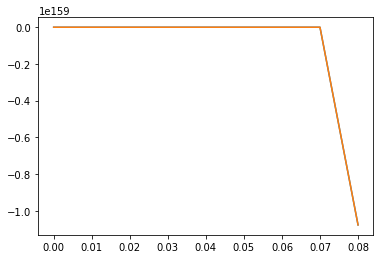

In [25]:
plt.plot(time_f,forecast[0,:])
plt.plot(time_f,forecast[1,:])
#plt.ylim(-10,15)

### Attempt 2 at forecasting